# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
probabilities = np.array([0.8, 0.2])
entropy = -np.sum(probabilities * np.log(probabilities))
print(round(entropy, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def index_gini(probs):
    return np.sum(probs * (1 - probs))

probabilities = np.array([0.8, 0.2])
left_probabilities = np.array([1, 0])
right_probabilities = np.array([1, 0])
print(round(index_gini(probabilities) - 0.8 * index_gini(left_probabilities) - 0.2 * index_gini(right_probabilities), 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
print(leaf.mean())

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def gini(probs):
    return np.sum(probs * (1 - probs))


def Q(targets, left_targets, right_targets, task: str):
    if task == 'classification':
        probs_targets = pd.Series(targets).value_counts(normalize=True)
        probs_left_targets = pd.Series(left_targets).value_counts(normalize=True)
        probs_right_targets = pd.Series(right_targets).value_counts(normalize=True)
        return gini(probs_targets) - (len(left_targets) / len(targets)) * gini(probs_left_targets) - (len(right_targets) / len(targets)) * gini(probs_right_targets)
    else:
        return np.var(targets) - (len(left_targets) / len(targets)) * np.var(left_targets) - (len(right_targets) / len(targets)) * np.var(right_targets)
    
def split(thresholds, feature_vector, target_vector, feature_type: str, task: str):
    if feature_type == 'real':
        left_targets = target_vector[feature_vector <= thresholds]
        right_targets = target_vector[feature_vector > thresholds]
    else:
        left_targets = target_vector[feature_vector == thresholds]
        right_targets = target_vector[feature_vector != thresholds]
    return Q(target_vector, left_targets, right_targets, task)


vectorized_split = np.vectorize(split, signature='(),(n),(n),(),()->()')   


def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    # Проверка на константый признак
    if len(feature_vector) <= 1:
        return list(), list(), 0, 0
    unique_feature_vector = np.unique(feature_vector)
    if feature_type == 'categorical':
        thresholds = np.unique(feature_vector)
    else:
        unique_feature_vector = np.sort(unique_feature_vector)
        thresholds = (unique_feature_vector[1:] + unique_feature_vector[:-1]) / 2
    ginis = vectorized_split(thresholds, feature_vector, target_vector, feature_type, task)
    min_index = np.argmax(ginis)
    threshold_best = thresholds[min_index]
    gini_best = ginis[min_index]
    return thresholds, ginis, threshold_best, gini_best


Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

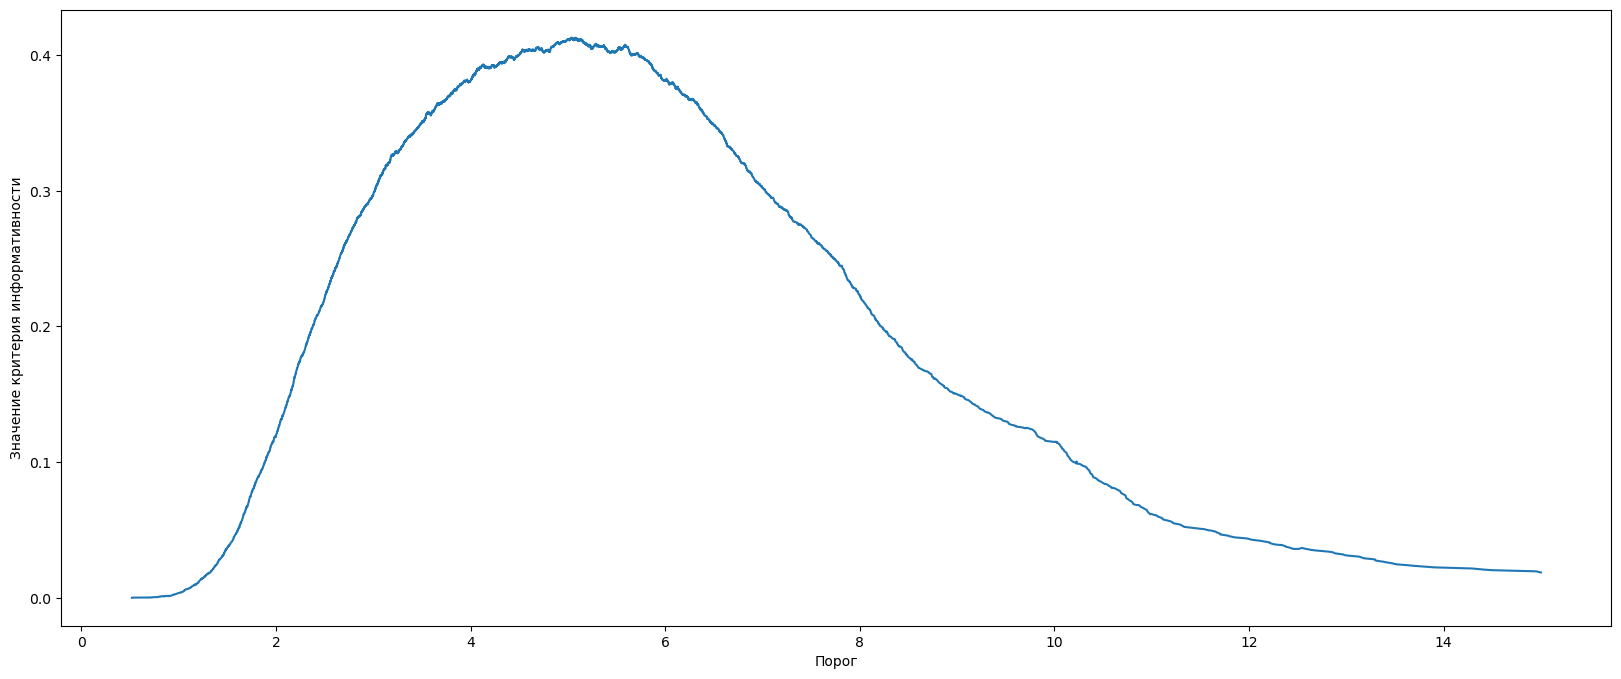

In [10]:
thresholds, ginis, threshold_best, gini_best = find_best_split(X['MedInc'], y, 'regression', 'real')
plt.figure(figsize=(20, 8))
plt.plot(thresholds, ginis)
plt.xlabel('Порог')
plt.ylabel('Значение критерия информативности')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
print(f'Лучший предикат имеет порог {threshold_best} и критерий информативности {gini_best}') # точка максимума на графике

Лучший предикат имеет порог 5.03515 и критерий информативности 0.4127513862016769


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия. (реализовал)**
- **Реализуйте метод оценки важности признаков. (реализовал)**

In [12]:
# Для бонуса заполнения пропусков. Решил заполнять медианным значениями. В целом, можно было бы и удалять строки с пропусками, но пропусков может быть слишком много
# Можно было бы ещё заполнить какой-то константной или предсказать значения))) 
# Но использовать ещё модели машинного обучения для заполнения пропусков в решающем дереве мне кажется странным
# Выведите переменную self._feature_importances, чтобы посмотреть, у кого самая большая важность
from sklearn.impute import SimpleImputer

In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        # Для боунса заполнения пропусков
        self._imputer = SimpleImputer(strategy="most_frequent")
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                if feature_best in self._feature_importances:
                    self._feature_importances[feature_best] += gini_best
                else:
                    self._feature_importances[feature_best] = gini_best
                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError
        
        # После выбора лучшего признака и порога для разделения, я добавлял улучшение критерия к важности соответствующего признака.
        # Потом всё нормирую, и признак, в котором значение больше в слова, имеет большуюю "важность"
        total = sum(self._feature_importances.values())
        normalized_importances = {}
        for feature, importance in self._feature_importances.items():
            normalized_importances[feature] = importance / total
        self._feature_importances = normalized_importances

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            raise ValueError


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self._imputer.fit_transform(X)
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [14]:
students = pd.read_csv('students.csv', index_col=0)
display(students)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


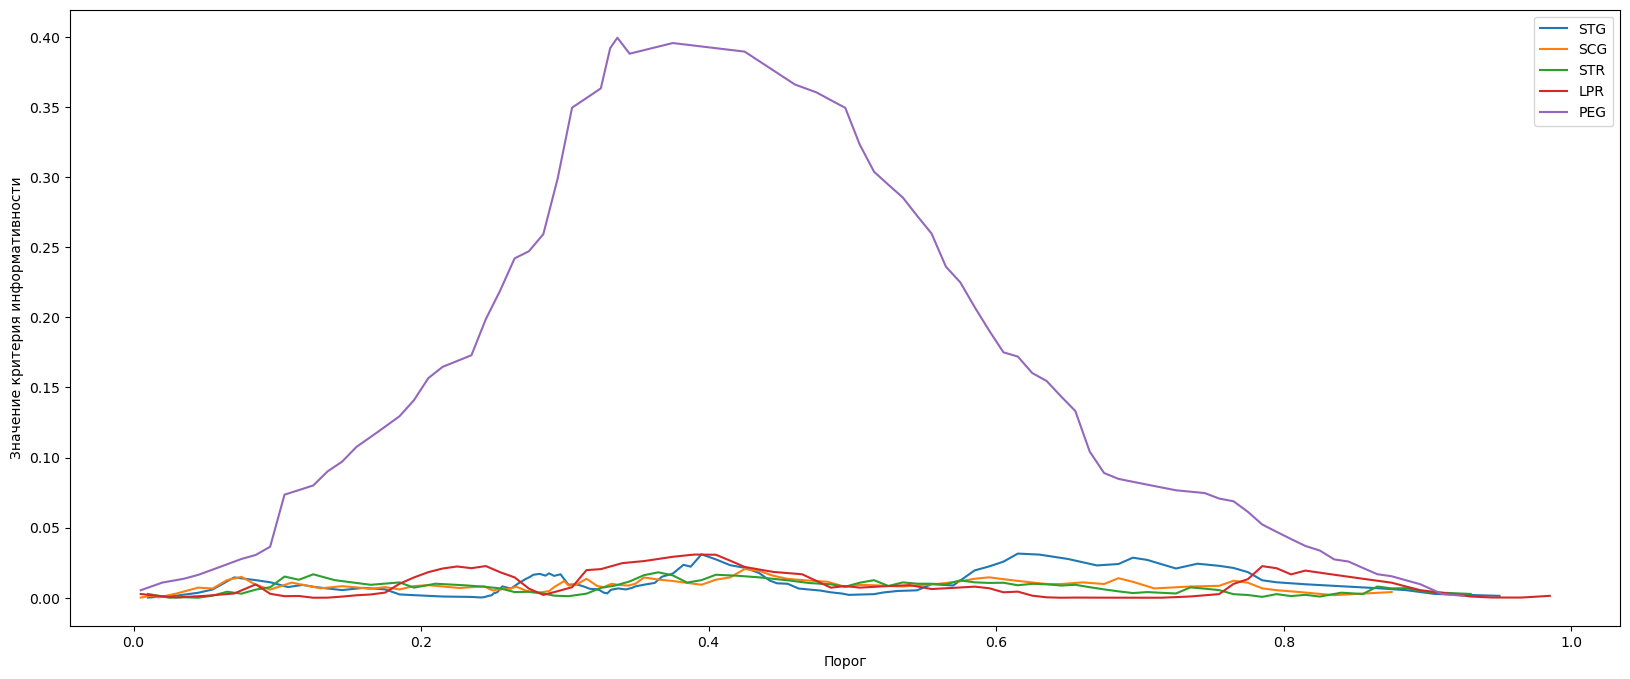

In [15]:
X = students.drop('UNS', axis=1)
y = students['UNS']
plt.figure(figsize=(20, 8))
for column in X.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        X[column], y, 'classification', 'real')
    plt.plot(thresholds, ginis, label=column)
plt.legend()
plt.xlabel('Порог')
plt.ylabel('Значение критерия информативности')
plt.show()

<AxesSubplot: xlabel='STG', ylabel='UNS'>

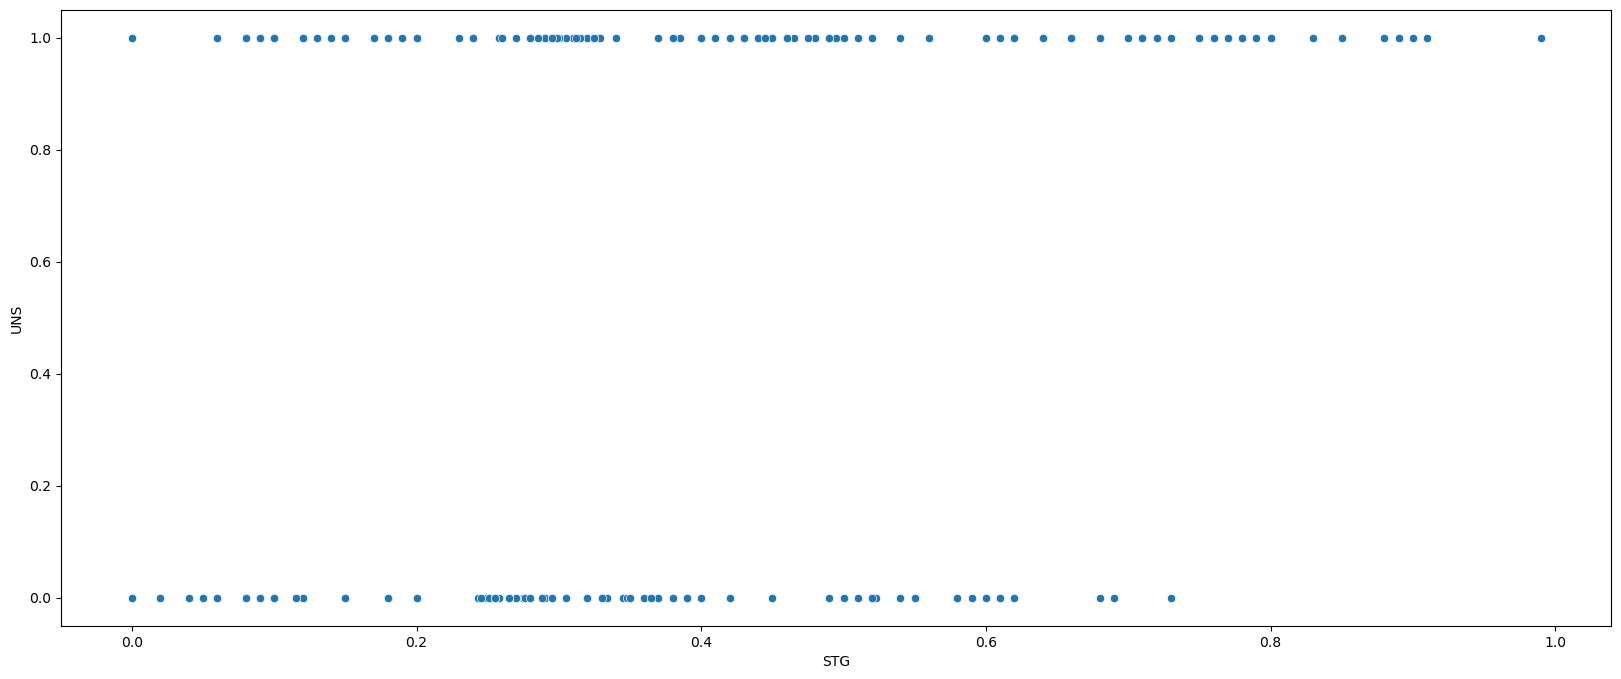

In [16]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=X['STG'], y=y)

<AxesSubplot: xlabel='SCG', ylabel='UNS'>

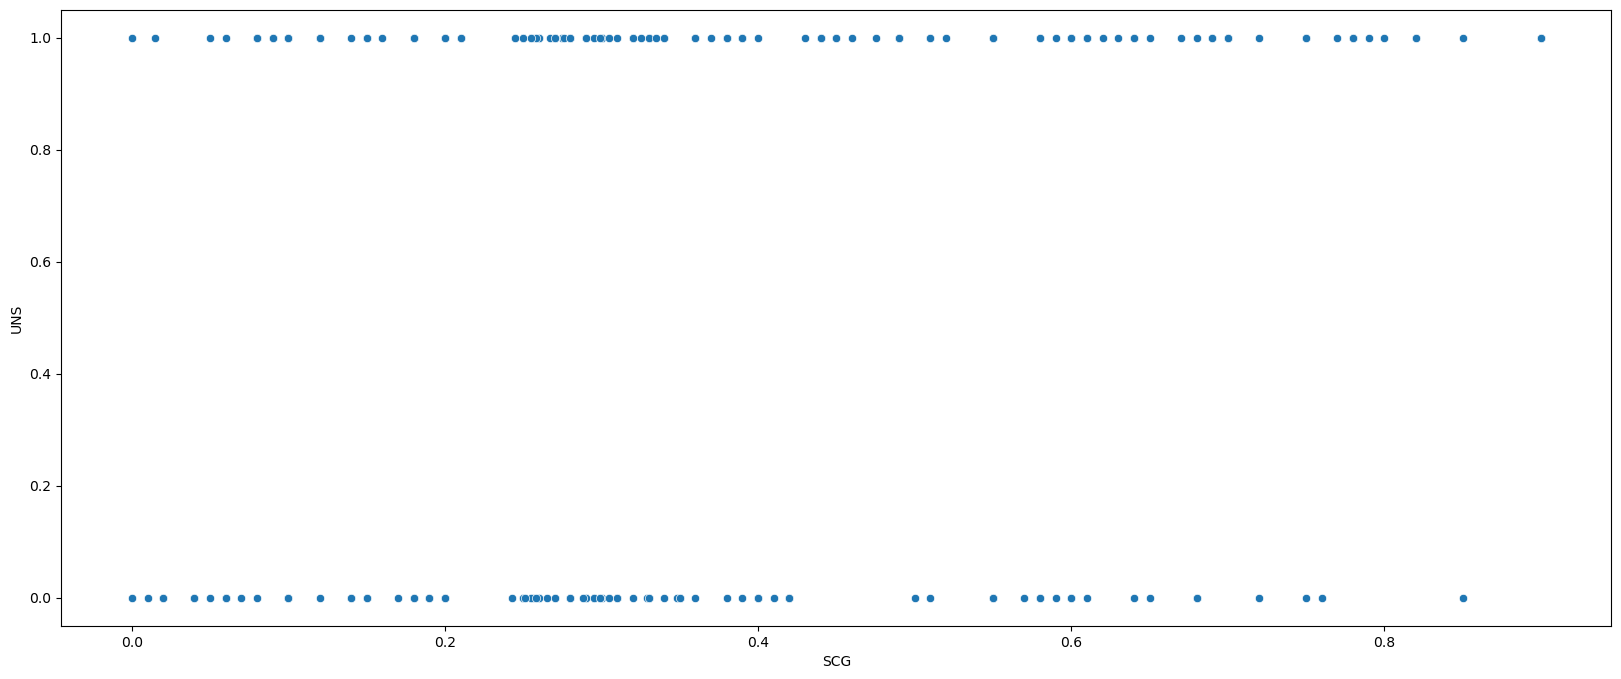

In [17]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=X['SCG'], y=y)

<AxesSubplot: xlabel='STR', ylabel='UNS'>

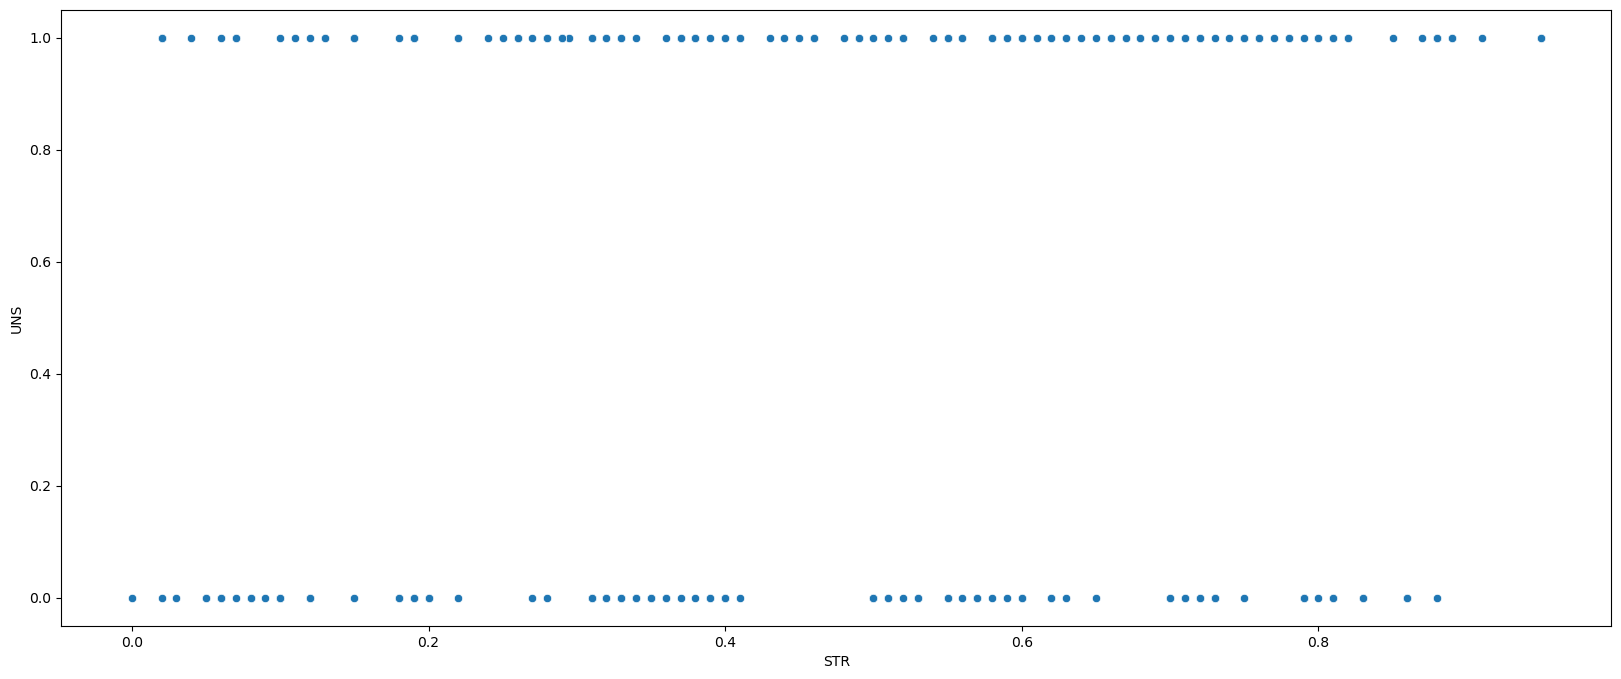

In [18]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=X['STR'], y=y)

<AxesSubplot: xlabel='LPR', ylabel='UNS'>

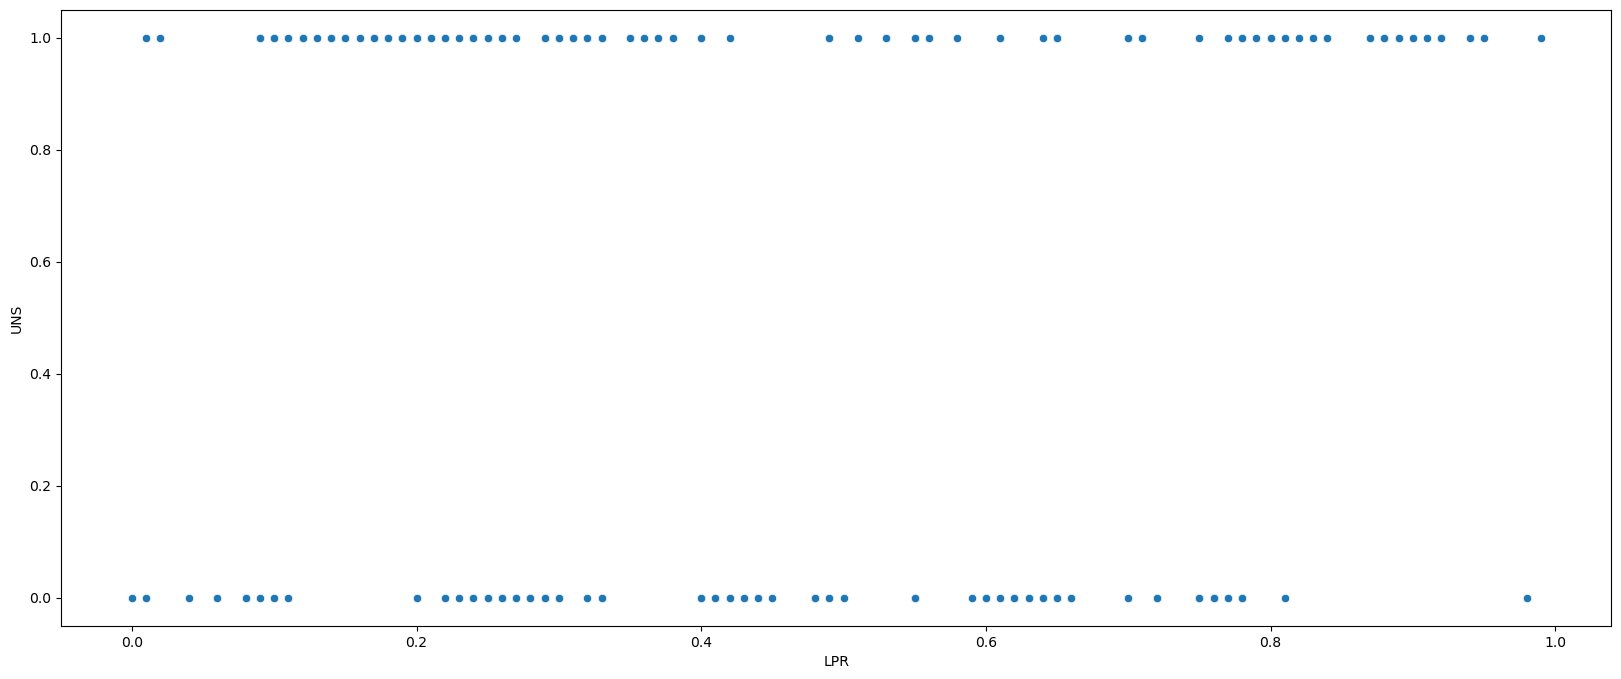

In [19]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=X['LPR'], y=y)

<AxesSubplot: xlabel='PEG', ylabel='UNS'>

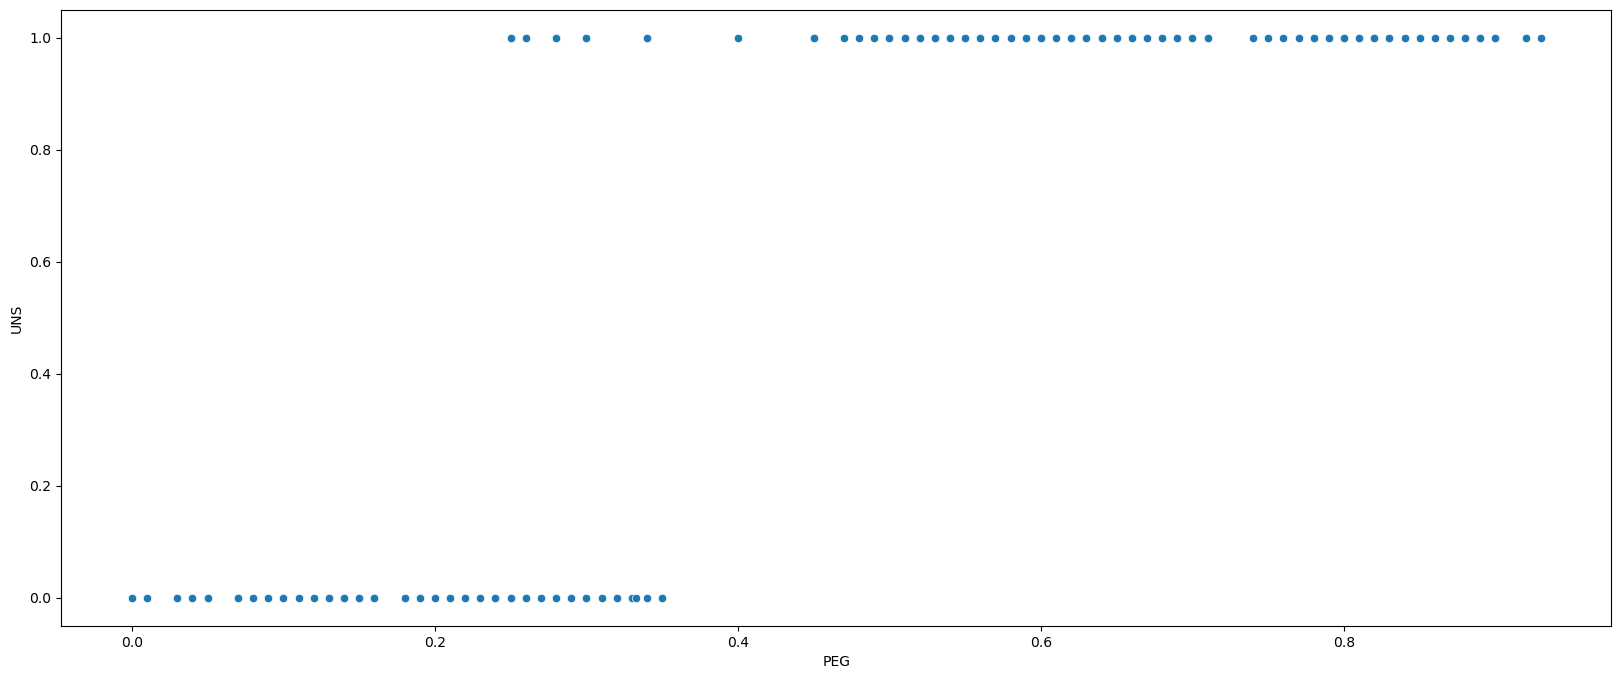

In [20]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=X['PEG'], y=y)


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

## Выводы:
* Исходя из кривых значений критерия Джини стоит разделять по признаку PEG.
* Этот результат согласуется с оценкой диаграмм рассеяния, видно разделение на пороге приблизительно равном 0.4
* Кривая для "хороших" признаков имеет холмик, по которому можно понять, как делить выборку
* Кривые признаков, по которым деление практически невозможно, выглядят 

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
label_encoder = LabelEncoder()
mushrooms = pd.read_csv('agaricus-lepiota.data')
display(mushrooms.head())
mushrooms = mushrooms.apply(label_encoder.fit_transform)
print('\n\n')
display(mushrooms.head())

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [23]:
X_train, X_test, y_train, y_test = train_test_split(mushrooms.drop('p', axis=1), mushrooms['p'], train_size=0.5, random_state=1256)
feature_types = ['categorical' for index in range(X_train.shape[1])]
tree = DecisionTree(feature_types=feature_types, task='classification')
tree.fit(X_train.to_numpy(), y_train.to_numpy())
# print(tree._feature_importances)
print('Accuracy:', accuracy_score(y_true=y_test.to_numpy(), y_pred=tree.predict(X_test.to_numpy())))


Accuracy: 0.9980305268340719


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [24]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier

In [25]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

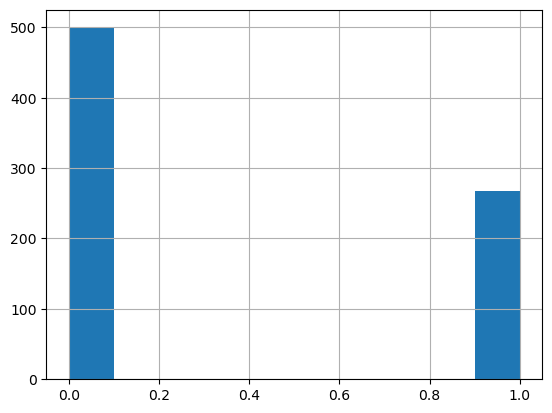

In [26]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [27]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1256)
X_train_train, X_train_validate, y_train_train, y_train_validate = train_test_split(X_train, y_train, train_size=0.7, random_state=1256)
print('Доля обучающей-обучающей выборки:', round(X_train_train.shape[0] / X.shape[0], 2))
print('Доля обучающей-валидационной выборки:', round(X_train_validate.shape[0] / X.shape[0], 2))
print('Доля тестовой выборки:', round(X_test.shape[0] / X.shape[0], 2))


Доля обучающей-обучающей выборки: 0.49
Доля обучающей-валидационной выборки: 0.21
Доля тестовой выборки: 0.3


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [28]:
max_depths = [i for i in range(1, 100)]
min_samples_leafs = [i for i in range(1, 50)]
best_score = 0.0
best_max_depth = 0
best_min_samples_leaf = 0
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        d_tree_classifier = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1256)
        d_tree_classifier.fit(X_train_train, y_train_train)
        validate_pred = d_tree_classifier.predict(X_train_validate)
        score = f1_score(y_true=y_train_validate, y_pred=validate_pred)
        if score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
print('Гипермараметры:')
print('best_score:', round(best_score, 3))
print('best_max_depth:', best_max_depth)
print('best_min_samples_leaf:', best_min_samples_leaf)


Гипермараметры:
best_score: 0.661
best_max_depth: 7
best_min_samples_leaf: 7


In [29]:
best_d_tree_classifier = DecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=1256)
best_d_tree_classifier.fit(X_train, y_train)
pred = best_d_tree_classifier.predict(X_test)
print('Accuracy:', round(accuracy_score(y_true=y_test, y_pred=pred), 3))
print('Presicion:', round(precision_score(y_true=y_test, y_pred=pred), 3))
print('Recall:', round(recall_score(y_true=y_test, y_pred=pred), 3))
print('ROC:', round(roc_auc_score(y_true=y_test, y_score=pred), 3))


Accuracy: 0.732
Presicion: 0.625
Recall: 0.698
ROC: 0.725


## Выводы
* Доля правильно угаданных ответов (Accuracy) довольно хорошая
* Точность низковата, как и полнота 

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [30]:
bagging = BaggingClassifier(n_estimators=50, random_state=1256)
bagging.fit(X_train, y_train)
pred = bagging.predict(X_test)

print('Accuracy:', round(accuracy_score(y_true=y_test, y_pred=pred), 3))
print('Presicion:', round(precision_score(y_true=y_test, y_pred=pred), 3))
print('Recall:', round(recall_score(y_true=y_test, y_pred=pred), 3))
print('ROC:', round(roc_auc_score(y_true=y_test, y_score=pred), 3))


Accuracy: 0.745
Presicion: 0.685
Recall: 0.581
ROC: 0.711


## Вывод:
* Всё стало получше, кроме полноты

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
max_depths = [i for i in range(1, 100, 10)]
min_samples_splits = [i for i in range(1, 50, 5)]
best_score = 0.0
best_max_depth = 0
best_min_samples_split = 0
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        forest = RandomForestClassifier(
            n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=1256)
        scores = cross_val_score(
            estimator=forest, X=X_train, y=y_train, scoring='f1')
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
print('Гипермараметры:')
print('best_score:', round(best_score, 3))
print('best_max_depth:', best_max_depth)
print('best_min_samples_split:', best_min_samples_split)


Гипермараметры:
best_score: 0.65
best_max_depth: 11
best_min_samples_split: 11


In [33]:
best_forest = RandomForestClassifier(
    n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=1256)
best_forest.fit(X_train, y_train)
pred = best_forest.predict(X_test)

print('Accuracy:', round(accuracy_score(y_true=y_test, y_pred=pred), 3))
print('Presicion:', round(precision_score(y_true=y_test, y_pred=pred), 3))
print('Recall:', round(recall_score(y_true=y_test, y_pred=pred), 3))
print('ROC:', round(roc_auc_score(y_true=y_test, y_score=pred), 3))

Accuracy: 0.749
Presicion: 0.679
Recall: 0.616
ROC: 0.722


## Выводы:
* Одно решающее дерево довольно хорошо отработало
* Бэггинг и Рандомный лес близки к друг другу, но тот же бэггинг гораздо быстрее работает (на моём компьютере в 2 раза и это с урезанным количеством тестируемых гиперпараметров), а выдаёт результаты чуть лучше даже рандомного леса.
* В итоге, на данном датасете для данной задачи лучше всего себя показали бэггинг и решающее дерево. Но в целом я бы отдал предпочтение бэггингу, так как Accuracy и Precision у него получше

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

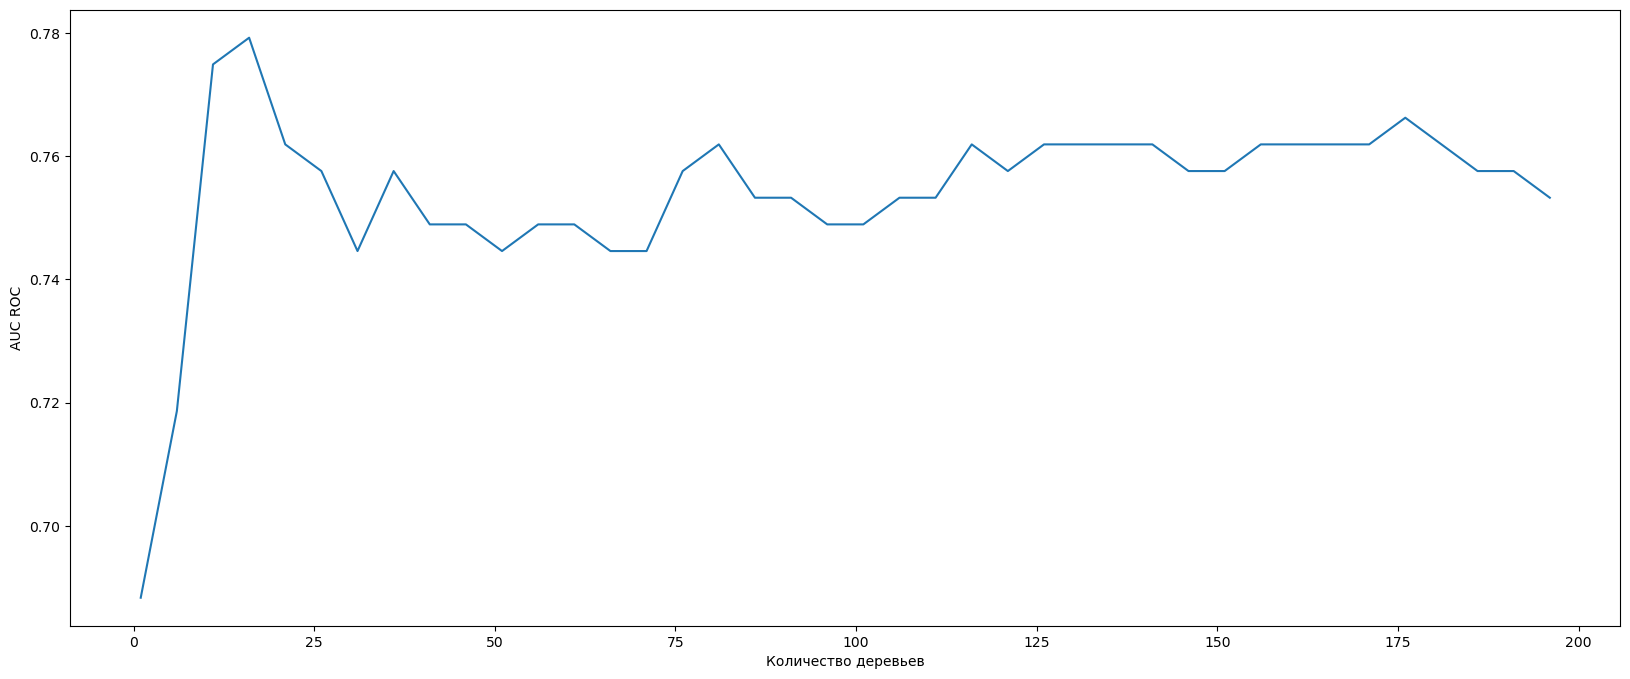

In [34]:
estimators = [i for i in range(1, 200, 5)]
auc_roc_scores = []
for estimator in estimators:
    forest = RandomForestClassifier(n_estimators=estimator, max_depth=best_max_depth,
                                     min_samples_split=best_min_samples_split, random_state=1256)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    auc_roc_scores.append(accuracy_score(y_true=y_test, y_pred=pred))

plt.figure(figsize=(20, 8))
plt.plot(estimators, auc_roc_scores)
plt.xlabel('Количество деревьев')
plt.ylabel('AUC ROC')
plt.show()    

## Выводы:
* AUC ROC метрика растёт примерно до 23 деревьев, но затем метрика идёт на резкое снижение и потом очень медленно и незначительно повышается
* Так что получается, что больше 23 деревьев смысла нет рассматирвать 

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<AxesSubplot: >

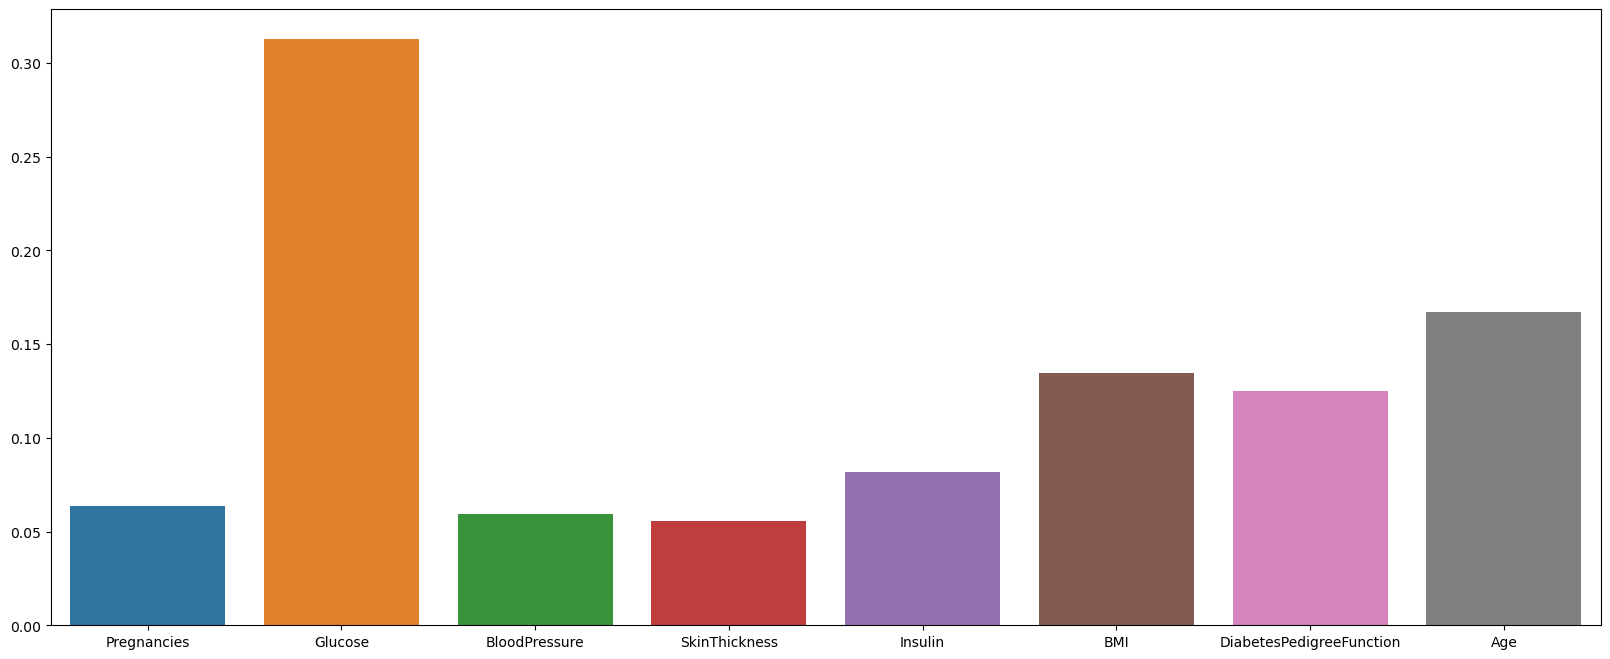

In [35]:
plt.figure(figsize=(20, 8))
sns.barplot(x=X.columns, y=best_forest.feature_importances_)

## Вывод:
* Самым важным признаком для предсказания сахарного диабета оказался уровень глюкозы. На втором месте возраст